In [30]:
## Run this cell if you need to install the required packages. If possible do not install directly in global environment.
# !pip install numpy
# !pip install matplotlib
# !pip install pandas
# !pip install scikit-learn
# !pip install seaborn
# !pip install imbalanced-learn

In [31]:
# Import standard libraries
import pandas as pd
import numpy as np
import joblib

# Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for processing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
# Import SMOTE for balancing dataset
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier

# Import measurement for evalutation
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score, balanced_accuracy_score, roc_auc_score

# Declare variables and import data

In [32]:
# Random value define to ensure the same result is obtained each time the code is run
np.random.seed(36)

In [33]:
# Set the path to the dataset
path_train = "./A1_dataset/Paitients_Files_Train.csv"
path_test = "./A1_dataset/Paitients_Files_Test.csv"

In [34]:
# Define type of columns
target_col = ['Sepssis'] # Target column binary classification 
num_cols = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']
drop_cols = ['ID', 'Insurance'] # Drop columns that are not needed

In [35]:
# Load the data
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)

In [36]:
def print_overview(data):
    # Check if there are any object (non-numeric) columns
    object_columns = data.select_dtypes(include='object').columns
    int_columns = data.select_dtypes(include='int64').columns
    
    # Display the top 3 rows
    print("Top 3 rows:" + '-'*70)
    display(data.head(3))

    # Display data types, missing values, and memory usage
    print("Data types, missing values, and memory usage:" + '-'*50)
    display(data.info())
    
    # Display summary statistics for numeric columns
    print("Summary statistics for numeric" + '-'*50)
    display(data.describe())
    print()
    print("Skewness for numeric" + '-'*50)
    display(data[int_columns].skew())
        
    # Conditionally display summary statistics for non-numeric columns
    print("Summary statistics for non-numeric" + '-'*50)
    if len(object_columns) > 0:
        display(data.describe(include='object'))

# Data Exploration
Using statistic and visual to explore the data.

In [37]:
print_overview(train)
#print_overview(test)

Top 3 rows:----------------------------------------------------------------------


,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive


Data types, missing values, and memory usage:--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


None

Summary statistics for numeric--------------------------------------------------


,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.824708,120.153589,68.732888,20.562604,79.460768,31.920033,0.481187,33.290484,0.686144
std,3.362839,32.682364,19.335675,16.017622,116.576176,8.008227,0.337552,11.828446,0.464447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.248000,24.000000,0.000000
50%,3.000000,116.000000,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000,1.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Skewness for numeric--------------------------------------------------


PRG          0.914008
PL           0.116180
PR          -1.874662
SK           0.164063
TS           2.401585
Age          1.152353
Insurance   -0.804257
dtype: float64

Summary statistics for non-numeric--------------------------------------------------


,ID,Sepssis
count,599,599
unique,599,2
top,ICU200010,Negative
freq,1,391


In [38]:
# Re-encode the target column to 0 (Negative - Not developing Sepsis) and 1(Positive - Will develop Sepsis)
train['Sepssis'] = train['Sepssis'].map({'Negative': 0, 'Positive': 1})

# Handling Missing Data

Replace place holder data 0 with NaN to determine how to preprocecssing them

In [39]:
# Removing columns that are not needed
train.drop(columns=drop_cols, inplace=True)
train.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepssis
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Visual Exploration

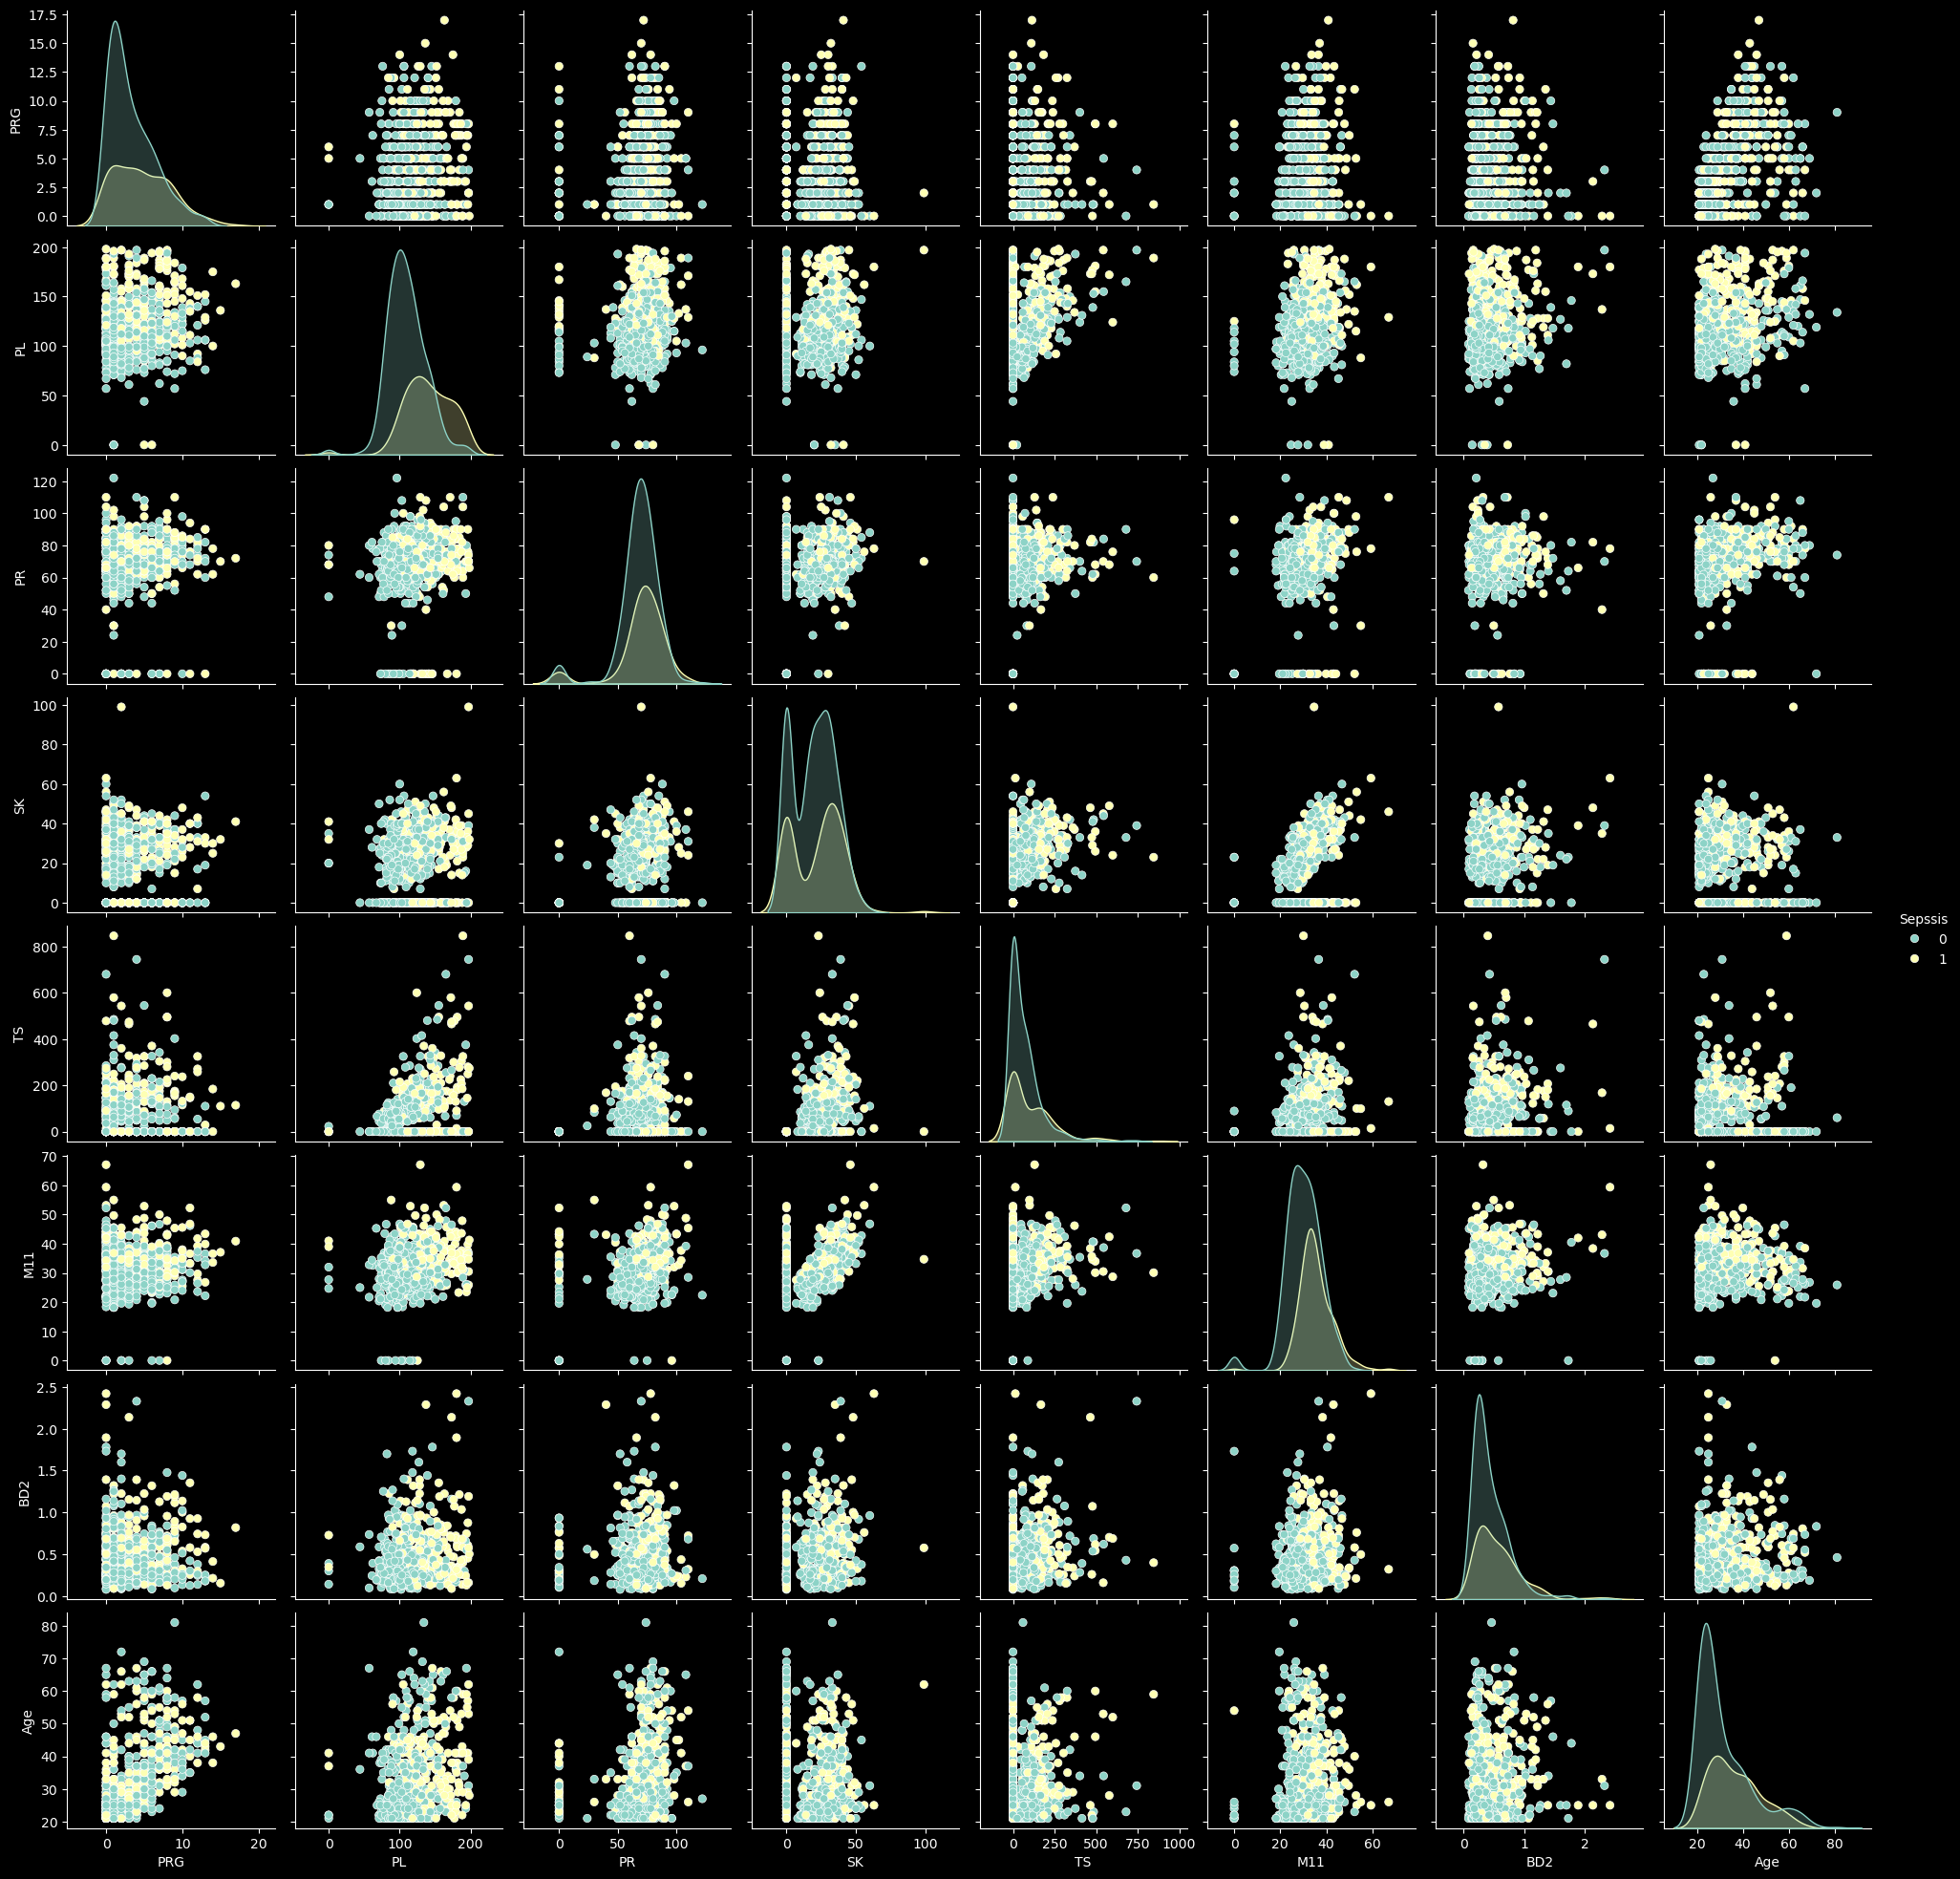

In [40]:
# Pairplot
sns.pairplot(train, hue = 'Sepssis')

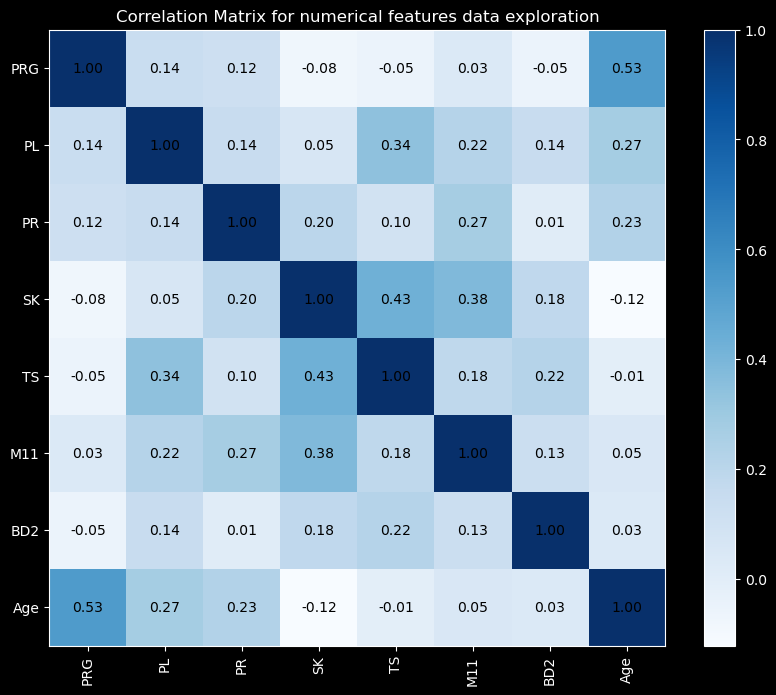

In [41]:
# correlation analysis
corrMatrix = train[num_cols].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(corrMatrix, cmap='Blues')
plt.title("Correlation Matrix for numerical features data exploration")
plt.colorbar()

# Add labels to the x-axis and y-axis
plt.xticks(range(len(corrMatrix.columns)), corrMatrix.columns, rotation=90)
plt.yticks(range(len(corrMatrix.columns)), corrMatrix.columns)

# Add the numerical data to each cell and format the text to center with back as the main color
for i in range(len(corrMatrix.columns)):
    for j in range(len(corrMatrix.columns)):
        plt.text(j,i ,f'{corrMatrix.iloc[i,j]:.2f}', ha = 'center', va = 'center', color ='black')

# Save the figure as an image
#plt.savefig('graphs/feature_cor_matrix.png')

In [42]:
# Replace 0 with NaN since most of the medical data measurement cannot be 0
train[num_cols] = train[num_cols].replace(value = np.nan, to_replace = 0)

In [43]:
# Check for missing values
train.isnull().sum()

PRG         93
PL           5
PR          28
SK         175
TS         289
M11          9
BD2          0
Age          0
Sepssis      0
dtype: int64

In [44]:
# Check the change in the data
train.describe()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepssis
count,506.000000,594.000000,571.000000,424.000000,310.000000,590.000000,599.000000,599.000000,599.000000
mean,4.527668,121.164983,72.103327,29.049528,153.538710,32.406949,0.481187,33.290484,0.347245
std,3.194089,30.893218,12.197850,10.750992,122.023594,7.021781,0.337552,11.828446,0.476492
min,1.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,2.000000,99.000000,64.000000,21.000000,74.000000,27.325000,0.248000,24.000000,0.000000
50%,4.000000,116.500000,72.000000,29.000000,120.000000,32.000000,0.383000,29.000000,0.000000
75%,7.000000,140.750000,80.000000,36.000000,190.000000,36.600000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [45]:
# Fill missing values with the median
train.fillna(train.median(), inplace=True)
# Review the shift in the data
train.describe()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepssis
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,4.445743,121.126043,72.098497,29.035058,137.357262,32.400835,0.481187,33.290484,0.347245
std,2.941454,30.766728,11.908878,9.042104,89.304012,6.968917,0.337552,11.828446,0.476492
min,1.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,2.000000,99.000000,64.000000,25.000000,115.000000,27.400000,0.248000,24.000000,0.000000
50%,4.000000,116.500000,72.000000,29.000000,120.000000,32.000000,0.383000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


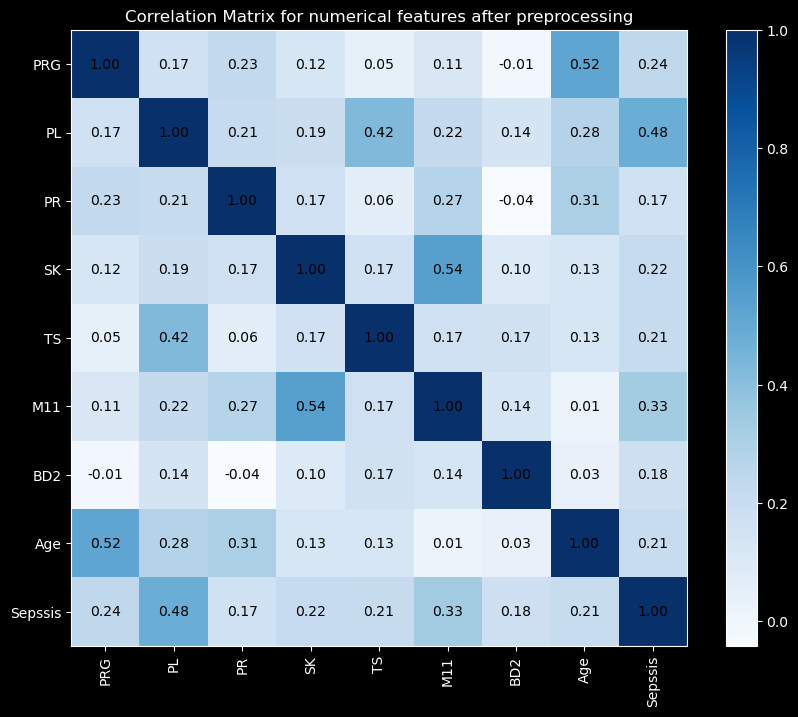

In [46]:
# correlation analysis
corrMatrix = train.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(corrMatrix, cmap='Blues')
plt.title("Correlation Matrix for numerical features after preprocessing")
plt.colorbar()

# Add labels to the x-axis and y-axis
plt.xticks(range(len(corrMatrix.columns)), corrMatrix.columns, rotation=90)
plt.yticks(range(len(corrMatrix.columns)), corrMatrix.columns)

# Add the numerical data to each cell and format the text to center with back as the main color
for i in range(len(corrMatrix.columns)):
    for j in range(len(corrMatrix.columns)):
        plt.text(j,i ,f'{corrMatrix.iloc[i,j]:.2f}', ha = 'center', va = 'center', color ='black')

# Save the figure as an image
#plt.savefig('graphs/feature_cor_matrix_2.png')

## Train dev and split

To support the process we will be splitting the training dataset into train-dev set and validate-dev set use for training and validatation

In [47]:
# Modify the data into features and target
X = train.drop('Sepssis', axis = 1) # Features
y = train['Sepssis'] # Target

In [48]:
# Change the df into numpy array for model training
X = np.array(X)
y = np.array(y)

# Check the shape of the data
print(X.shape)
print(y.shape)

(599, 8)
(599,)


In [49]:
# Train-dev and validation split for model training, stratify to ensure the same distribution of classes
X_train_dev, X_val, y_train_dev, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 0)

In [50]:
X_train_dev.shape, X_val.shape, y_train_dev.shape, y_val.shape

((479, 8), (120, 8), (479,), (120,))

# Operation Function

In [51]:
# Class to store all models and their performance
class ModelsPerformance:
    def __init__(self):
        self.models = []
        self.results = []

    def add_model(self, model): # Add newly trained model to the list
        self.models.append(model)
        self.save_result(model)

    def save_result(self, model): # Save the result in a list
        # Create a dictionary to store the results
        result = {
            'Model': model.__class__.__name__,
            'Recall': model['Recall'],
            'F1 Score': model['F1 Score'],
            'Balanced Accuracy': model['Balanced Accuracy'],
            'ROC AUC': model['ROC AUC']
        }
        self.results.append(result)

    def result_to_csv(self, file_name='model_performance.csv', return_df=False):
        # print the result in a csv file for further analysis
        result_df = pd.DataFrame(self.results)
        result_df.to_csv(file_name, index=False)
        if return_df:
            return result_df
        print('Result saved to', file_name)

In [52]:
# Fit and print the training result (Taken from lab05_Classification_bank notebook for Python Intro to Data Science)
def train_and_plot(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)

    print("Model accuracy for training set: ", model.score(X_train, y_train))
    print("Model accuracy for test set: ", model.score(X_test, y_test))

    y_pred = model.predict(X_test)

    print("Recall: ", recall_score(y_test, y_pred))
    print("F1 Score: ", f1_score(y_test, y_pred))
    print("Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))
    print("ROC AUC: ", roc_auc_score(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return model 

In [53]:
# Final model output result as required by the assignment

def final_predict(model, test_data, name):
    """
    This function prints the results of the model
    """
    # Load the test data
    X = test_data.drop(columns=drop_cols)
    y = test_data['Sepssis']

    model.fit(X, y)


    prediction_df = pd.DataFrae({
        'ID': test_data['ID'],
        'Sepsis': model.predict(X)
    })

    prediction_df.to_csv(name, index = False)

    print("The prediction has been saved as: ", name)

# Data Preprocess

Using StandardScaler for numeric values to reduce difference

In [54]:
# Import libraries for create pipelien
from imblearn.pipeline import Pipeline # Use imbalanced-learn pipeline to handle imbalance dataset
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import RobustScaler

In [55]:
# Apply SMOTE to balance the dataset
sm = SMOTE()
X_train_dev_reb, y_train_dev_reb = sm.fit_resample(X_train_dev, y_train_dev)

In [56]:
# Scale the feature
scaler = RobustScaler() # Use RobustScaler to scale the data since it is robust to outliers
X_train_dev_reb = scaler.fit_transform(X_train_dev_reb)
X_val = scaler.transform(X_val)

# Model Comparion

Since the task is prediction of the class we will be starting with some simple model and moving it forward:

* Logistic Regression
* Simple K-mean
* SGD Classification
* Decision Tree
* RandomForestClassifier

Initally each model will be running using the training-dev and using CV technique (we will be using this since there is a small number of dimension in the data) to hyper tune each model. 

In [57]:
# Define the models to be used
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(), 
    #'SGD': SGDClassifier(),
    'Decision Tree': DecisionTreeClassifier(), 
    'Random Forest': RandomForestClassifier(),
    }

In [58]:
# Final model tuning
import warnings
from sklearn.model_selection import RandomizedSearchCV

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Define the list of parameter to search for 
param_distributions = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    'KNN': {'n_neighbors': range(1,21)},
    'Decision Tree': {'max_depth': range(1,21)},
    'Random Forest': {'n_estimators': (10, 110), 'max_depth': range(1, 21)}
}

# Iterate throught the list of model and tune the hyperparameter
for name, model in models.items():
    print(f'Tuning {model}')
    RandomSearch = RandomizedSearchCV(model, param_distributions[name], n_iter=100, cv=5, scoring = 'f1')
    RandomSearch.fit(X_train_dev_reb, y_train_dev_reb)

    best_model = RandomSearch.best_estimator_
    y_pred = best_model.predict(X_val)
    
    print(f'Best parameters: {RandomSearch.best_params_}')
    print(f'F1 Score: {f1_score(y_val, y_pred)}')
    print(f'ROC AUC Score: {roc_auc_score(y_val, best_model.predict_proba(X_val)[:, 1])}')
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    print()
    print("-"*50)

Tuning LogisticRegression()


Best parameters: {'C': 10}
F1 Score: 0.611764705882353
ROC AUC Score: 0.8107448107448106
              precision    recall  f1-score   support

           0       0.79      0.78      0.79        78
           1       0.60      0.62      0.61        42

    accuracy                           0.72       120
   macro avg       0.70      0.70      0.70       120
weighted avg       0.73      0.72      0.73       120

[[61 17]
 [16 26]]

--------------------------------------------------
Tuning KNeighborsClassifier()
Best parameters: {'n_neighbors': 1}
F1 Score: 0.5301204819277109
ROC AUC Score: 0.6401098901098901
              precision    recall  f1-score   support

           0       0.75      0.76      0.75        78
           1       0.54      0.52      0.53        42

    accuracy                           0.68       120
   macro avg       0.64      0.64      0.64       120
weighted avg       0.67      0.68      0.67       120

[[59 19]
 [20 22]]

-------------------------------------

Since we run the risk of predicing the wrong range, random decision search would in theory proven to have better result than initial guessing.

# Final Model Result

Final model is the best model after the use of our above technique, we will then further tune it using the entirer train dataset prior to test it against the test dataset.

In [59]:
# Create a pipeline for the best model
best_model = LogisticRegression(C=0.1)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_model)
])

# Fit the model
final_model = pipeline.fit(X,y)

In [60]:
# Reshape test data for prediction
test_prep = test.drop(columns=drop_cols)
test_prep.head()


,PRG,PL,PR,SK,TS,M11,BD2,Age
0,1,109,38,18,120,23.1,0.407,26
1,1,108,88,19,0,27.1,0.400,24
2,6,96,0,0,0,23.7,0.190,28
3,1,124,74,36,0,27.8,0.100,30
4,7,150,78,29,126,35.2,0.692,54


In [61]:
test_features = np.array(test_prep)
test_features.shape

(169, 8)

In [62]:
test_predic = final_model.predict(test_features)

In [63]:
np.unique(test_predic).size


2

In [64]:
# Create a new dataframe to store the prediction which contain only ID and Prediction
prediction_df = pd.DataFrame({
    'ID': test['ID'],
    'Sepssis': test_predic
})

prediction_df.describe()

,Sepssis
count,169.000000
mean,0.242604
std,0.429931
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [65]:
prediction_df.to_csv('03_PREDICTION_DangQuang_s3676330.csv', index=False)